#  Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Цель исследования

Спрогнозировать количество заказов такси на следующий час.

## Ход исследования

- Подгатовка данных: Загрузка и изучение общей информации из предоставлено датасета.
- Предоработка данных: Обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
- Исследовательский анализ данных: Изучение основных параметров объектов, их распределение, присутствие выбросов,  явление и обработка аномали
- Анализ коррелации: Исследование связи между признаками чтобы понимать если нужно или нет установить несколко признаков
- Построение пайплайн с методом оптимизации чтобы отобрать самую лучшую модель для МО
- Анализ важности признаков чтобы понимать какие признаки важны и какие нет
- Сравнение моделей по качество предсказания, время обучения, скорость предсказания чтобы наидтйи лучшее модель
- Тестирование модель с метриком RMSE 

# Подготовка

## Установление и импорт модули

In [1]:
# установка модулей

!pip install -U -q seaborn 
!pip install -U -q scikit-learn

!pip install -q phik

!pip install -U -q matplotlib

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import lightgbm as lgb

# train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем нужные модели для classification
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import RandomizedSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error

## Закгужка данных

In [3]:
df_orgn = pd.read_csv('/datasets/taxi.csv', index_col = ['datetime'], parse_dates = ['datetime'])

In [4]:
df_orgn.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df_orgn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Наш датафрейм содержит 26496 объектов, один столбец: количество заказов, «num_orders», наш целовой признак, содержащая числовые значения. Индекс представляет собой временной ряд, которые идёт с 2018-03-01 00:00:00 до 2018-08-31 23:50:00. 

Y нас нет пропущенных значений.

## Порядок индексов

In [6]:
# Проверка того, монотонно ли увеличивается индекс
df_orgn.index.is_monotonic_increasing

True

## Пропуски

Мы видели с методом info() что у нас нет пропусков.

## Дубликаты

Так как у нас толко один столбец и как мы проверили что индекс монотонно увеличивается, мы можем говорить что у нас нет дубликатов!

## Ресемплинг

In [7]:
# Сделаем ресемплинг по одному часу
df = df_orgn.resample('1H').sum();

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресемплинг прошол хорошо!

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Сейчас у нас всего 4410 объектов.

## Вывод

Мы загрузили нашу базу данных, установив столбец datetime (временные ряды) в качестве индекса. Мы проверили, что эти значения монотонно возрастали. 
Мы также замечали, что в нашем датафрейме нет ни пропущенных значений, ни дубликатов. 

# Анализ

## Статистический анализ

In [10]:
df_stat = df['num_orders'].describe()
df_stat

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

В среднем у нас около 84 заказов в час. Однако у нас также есть стандартное отклонение в 45 заказов в час, что составляет более 50% от среднего значения и минимальное значение, равное 0 (когда аэропорт закрыт?). Мы видим, что в течение дня у нас много вариаций, есть часы пик и минимум.

## Боксплот

## Скользящее среднее за августе

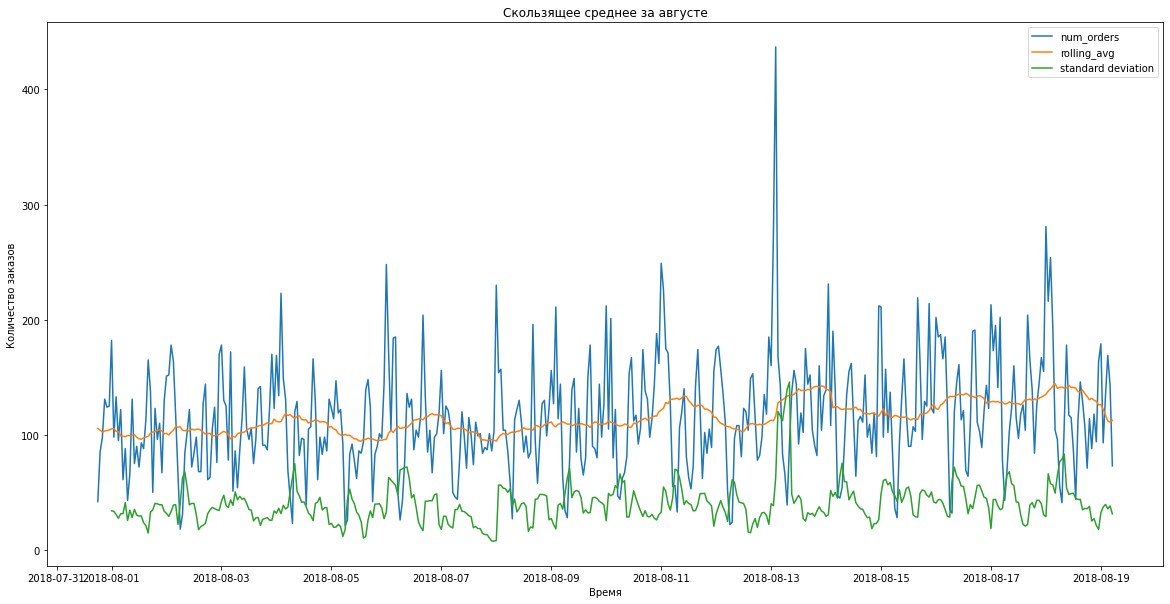

In [13]:
# Plotting the results
fig, ax = plt.subplots(figsize=(20, 10))

df['rolling_avg'] = df['num_orders'].shift().rolling(24).mean()

sns.lineplot(data=df.iloc[3666:4110], x=df.iloc[3666:4110].index, y='num_orders', label='num_orders', ax=ax);
sns.lineplot(data=df.iloc[3666:4110], x=df.iloc[3666:4110].index, y='rolling_avg', label='rolling_avg', ax=ax);
sns.lineplot(data=df.iloc[3666:4110], x=df.iloc[3666:4110].index, y=df.iloc[3666:4110]['num_orders']\
                     .shift().rolling(6).std(), label='standard deviation', ax=ax);
ax.set_title('Скользящее среднее за августе');
ax.set_xlabel('Время');
ax.set_ylabel('Количество заказов');
ax.legend();

df = df.drop('rolling_avg', axis=1)

Используя скользящее среднее за 24 часов, мы видим, что получили более плавный тренд.

## Тренд и сезонность по часов в дне

In [14]:
# Разложение нашей датафреймы
decomposed = seasonal_decompose(df['num_orders'])

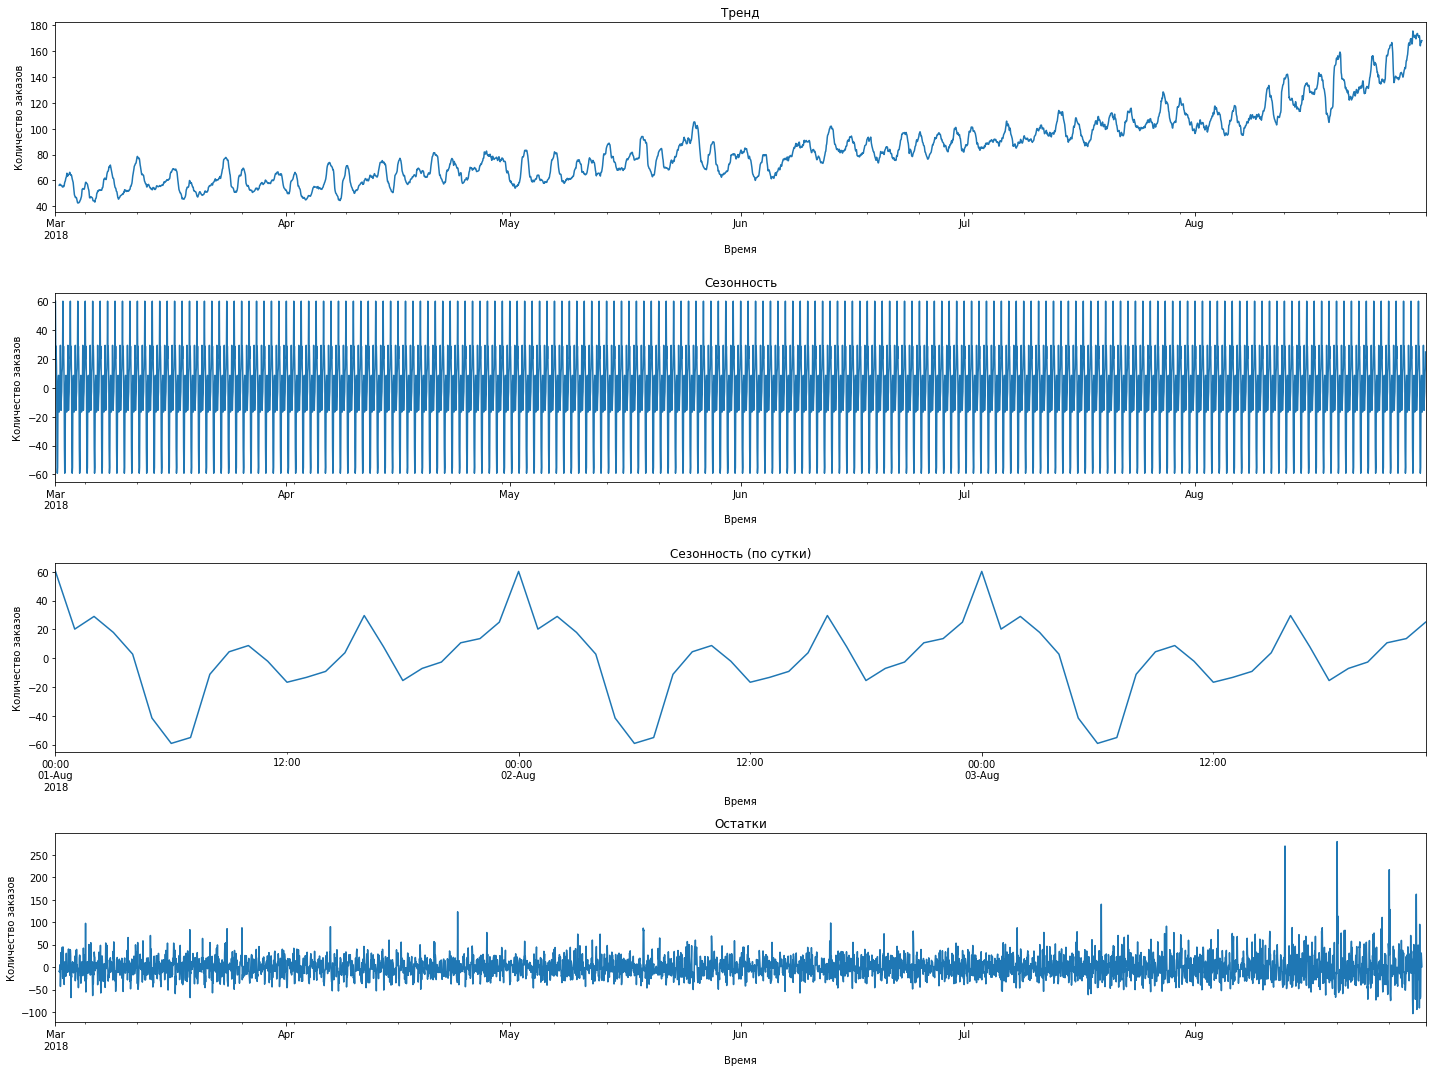

In [15]:
# Фигуры
fig, ax = plt.subplots(nrows = 4, ncols =1, figsize=(20, 15))

decomposed.trend.plot(ax=ax[0]);
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Количество заказов')
ax[0].set_title('Тренд')
decomposed.seasonal.plot(ax=ax[1]);
ax[1].set_xlabel('Время')
ax[1].set_ylabel('Количество заказов')
ax[1].set_title('Сезонность')
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=ax[2]);
ax[2].set_xlabel('Время')
ax[2].set_ylabel('Количество заказов')
ax[2].set_title('Сезонность (по сутки)')
decomposed.resid.plot(ax=ax[3])
ax[3].set_xlabel('Время')
ax[3].set_ylabel('Количество заказов')
ax[3].set_title('Остатки')
plt.tight_layout()

Судя по тенденции, мы видим, что количетсво заказов начинает действительно увеличиваться с мая, когда люди начинают ходить в отпуск.

Изучая сезонность, мы видим, что заказы начинают увеличиваться около 18:00, а пик приходится на полночь, после чего он медленно снижается. Около 2:00 у нас небольшое увеличение, вероятно, из-за закрытия аэропорта. В связи с закрытием аэропорта и остановкой рейсов наблюдается резкое снижение заказов примерно до 6:00. С этого времени и, конечно же, из-за возобновления работы аэропорта, более ранние заказы начинают увеличиваться в среднем до 10. С 10 до 12 заказов снижается. С 12:00 до 16:00 заказы увеличиваются до 16:00. Отсюда снова снижение до 18:00.

## Сезонность по дням недели

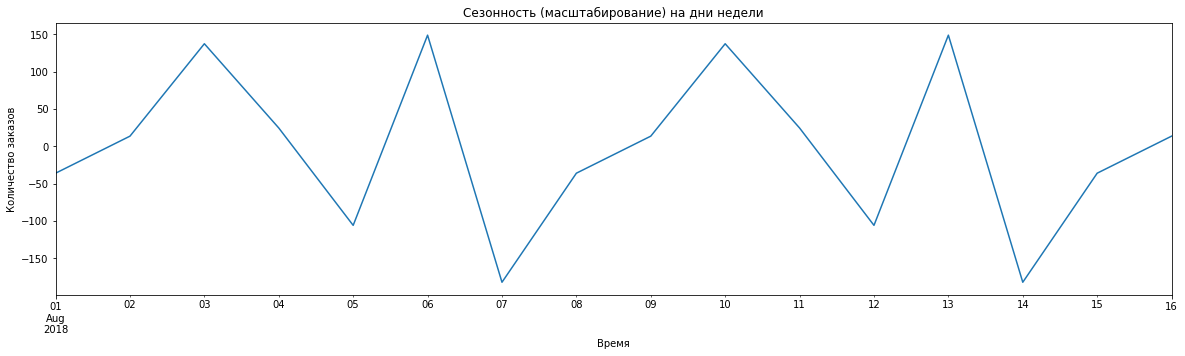

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
seasonal_decompose(df_orgn.resample('1D').sum()['num_orders']).seasonal['2018-08-01':'2018-08-16'].plot();
ax.set_xlabel('Время');
ax.set_ylabel('Количество заказов');
ax.set_title('Сезонность (масштабирование) на дни недели');

1 августа 2018 года было среда.Мы видим, что для дней недели у нас были минимумы по вторникам и воскресеньям, и
были пики по пятницам и понедельникам, первый и последний рабочий день. 

## Features engineering

После EDA мы заметили, что у нас есть сезонность по дням недели и часам. Затем мы создаем признакии по дням недели и часам.

In [17]:
#  Создадим функцию для добавления функции в наш датафрейм
def make_features(dataframe, target, max_lag, rolling_avg_size):
    # Признак по времени
    dataframe['day_of_week'] = dataframe.index.dayofweek
    dataframe['hour'] = dataframe.index.hour
    
    # lag 
    for lag in range(1, max_lag + 1):
        dataframe[f'lag_{lag}'] = dataframe[target].shift(lag)
        
    # скользящее среднее
    dataframe['rolling_avg'] = dataframe[target].shift().rolling(rolling_avg_size).mean()

In [18]:
# Применение функции make_features
make_features(df, 'num_orders', 168, 168)

In [19]:
# Проверяем наши новые признаки
df.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_avg
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Удаление дубликатов, которые мы создали с помощью методами shift и rolling
df = df.dropna()

## Корреляционный анализ

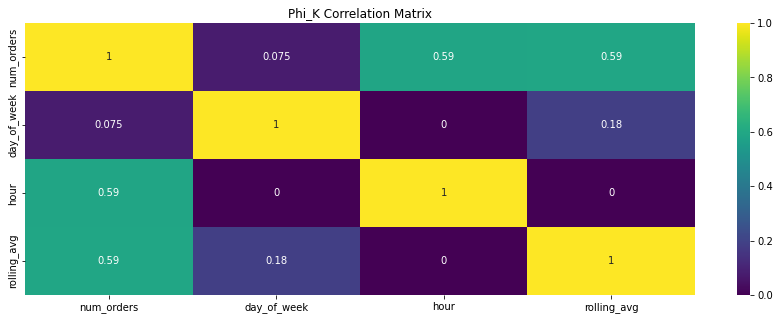

In [21]:
# Выбираем столбцы с числовым значением
col_corr = ['num_orders', 'day_of_week', 'hour', 'rolling_avg']
interval_cols = ['num_orders', 'rolling_avg']

# Вычисляем матрицу корреляции с использованием phik
corr_matrix = df[col_corr].phik_matrix(interval_cols=interval_cols)

# Визуализация матрицы 
plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='viridis');
plt.title('Phi_K Correlation Matrix')
plt.show()

Мы видим, в датафрейме без 'lags' что наш целовой признак больше всего зависит от 'hour' и 'rolling_avg'.

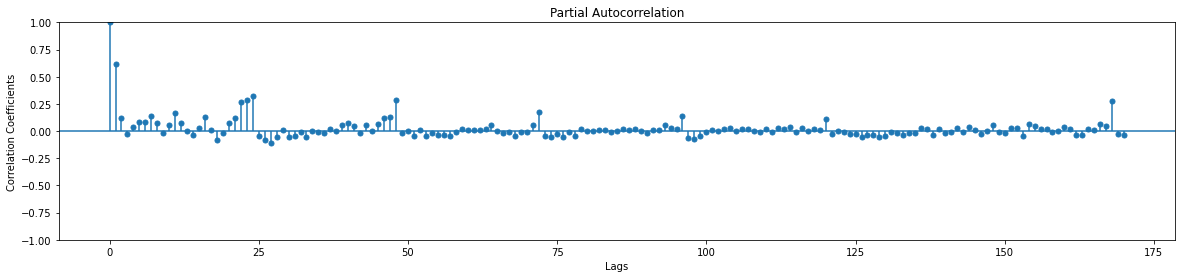

In [22]:
plot_pacf(df['num_orders'], alpha=None, method='ywm', lags=170).set_size_inches(20, 4)
plt.xlabel('Lags')
plt.ylabel('Correlation Coefficients')
plt.show()

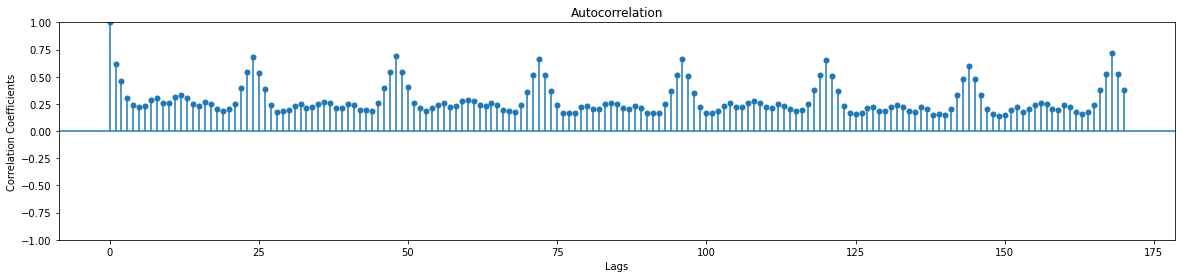

In [23]:
plot_acf(df['num_orders'], alpha=None, lags=170).set_size_inches(20, 4)
plt.xlabel('Lags')
plt.ylabel('Correlation Coefficients')
plt.show()

Что касается частичной автокорреляции, мы видим, что первая, 22-я, 23-я и 24-я лаги имеют самую сильную корреляцию.

Что касается автокорреляции, мы видим сильную корреляцию для первых двух лагов и 22-го, 23-го, 24-го, 25-го, 26-го, 27-го. Это повторяется в течение недели.

## Вывод

Мы видили, что заказы имеют тенденцию к увеличению, начиная с конца апреля-начала мая, когда люди начинают взять отпуск, причем наибольшее количество заказов приходится на август.

В заключение мы видим, что у нас есть один большой пик в 0:00 и один огромный минимум около 6:00. Максимум заказов происходит с 23:00 до 2:00. Возможно, это связано с тем, что аэропорт закрывается ночью. У нас также есть пик в днем в 16:00, но он не так высокий, как ночью.

Самое спокойное время это от 2:00 до 6:00 (когда нет рейсов). 

День где происходит болшее заказов - пятница и понеденльник, первый и последний рабочий день. 

Мы создали некоторые признаков для нашей модели, такие как признаки времени («день_недели», «час»), а также 'lag' признаки (24, один суток) и скользящее среднее значение на 168 часов (один недели).

По поводу коррелации, самые значительние коэффициент для целового признака - 'hour', 'rolling_avg', 'lag_1', 'lag_2', 'lag_22', 'lag_23' и 'lag_24'.

# Обучение

Мы собираемся использовать 4 различные модели регрессии в алгоритме RandomizedSearchCV, а именно:
- LinearRegression(),
- LGBMRegressor(),
- RandomForestRegressor()
- KNeighborsRegressor() 

## Разделение датасет в тренировочном и тестировочном датасете

In [24]:
# Отделение вашей целовой признака от датафреймы
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [25]:
# Разделение на треннировчной и тестовой

TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(
                                    X, 
                                    y, 
                                    shuffle=False, 
                                    test_size=TEST_SIZE) 

In [26]:
# Проверка индексов нашего датафрейма
X_train.tail().index, X_test.head().index

(DatetimeIndex(['2018-08-14 02:00:00', '2018-08-14 03:00:00',
                '2018-08-14 04:00:00', '2018-08-14 05:00:00',
                '2018-08-14 06:00:00'],
               dtype='datetime64[ns]', name='datetime', freq='H'),
 DatetimeIndex(['2018-08-14 07:00:00', '2018-08-14 08:00:00',
                '2018-08-14 09:00:00', '2018-08-14 10:00:00',
                '2018-08-14 11:00:00'],
               dtype='datetime64[ns]', name='datetime', freq='H'))

## Пайплайн

In [27]:
df.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_avg
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


In [28]:
# преобразование дней и часов в целое число, чтобы иметь возможность 
# выбирать другие функции с помощью select_dtypes(include='float64')
df[['day_of_week', 'hour']] = df[['day_of_week', 'hour']].astype('int')

In [29]:
# Разделаем нашы столбцы на числовые и категориальные

num_col = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()

num_pipe = Pipeline([
    ('scaler', MinMaxScaler())
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
    ('num', num_pipe, num_col)
    ], 
    remainder='passthrough'
)

In [30]:
RANDOM_STATE = 42
# Параметры моделей
param_grid = [
     # словарь для модели LinearRegression()
    {
        'model': [LinearRegression()]
    },
     # словарь для модели LGBMRegressor()
    {
        'model': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100],
        'model__learning_rate': [1e-2, 0.1],
        'model__num_leaves': [2, 10],
        'model__min_data_in_leaf': [2, 10]
    },
     # словарь для модели RandomForestRegressor()
    {
        'model':[RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [48, 56, 64],
        'model__max_features': [10, 14],
        'model__min_samples_split':[10, 14],
        'model__min_samples_leaf':[20, 23],
        'model__max_depth': [20, 23]
      },
    # словарь для модели KNeighborsRegressor() 
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': range(2,5)
   }]

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
                        pipe_final, 
                        param_grid, 
                        cv=tscv,
                        scoring='neg_root_mean_squared_error',
                        random_state=RANDOM_STATE,
                        error_score="raise",
                        verbose = 3,
                        n_jobs=-1
                    )

randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ........model=LinearRegression();, score=-20.298 total time=   0.3s
[CV 2/5] END ........model=LinearRegression();, score=-20.974 total time=   0.4s
[CV 3/5] END ........model=LinearRegression();, score=-21.726 total time=   0.5s
[CV 4/5] END ........model=LinearRegression();, score=-22.350 total time=   0.4s
[CV 5/5] END ........model=LinearRegression();, score=-28.101 total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__min_data_in_leaf=2, model__n_estimators=100, model__num_leaves=2;, score=-19.671 total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__min_data_in_leaf=2, model__n_estimators=100, model__num_leaves=2;, score=-21.587 total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__min_data_in_leaf=2, model__n_estimators=100, model__num_leaves=2;, score=-21.764 total time=   0.4s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__min_data_in_leaf=2, model__n_estimators=100, model__num_leaves=2;, score=-22.004 total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__min_data_in_leaf=2, model__n_estimators=100, model__num_leaves=2;, score=-30.346 total time=   0.6s
[CV 1/5] END model=RandomForestRegressor(random_state=42), model__max_depth=23, model__max_features=10, model__min_samples_leaf=20, model__min_samples_split=14, model__n_estimators=48;, score=-23.286 total time=   0.2s
[CV 2/5] END model=RandomForestRegressor(random_state=42), model__max_depth=23, model__max_features=10, model__min_samples_leaf=20, model__min_samples_split=14, model__n_estimators=48;, score=-24.556 total time=   0.2s
[CV 3/5] END model=RandomForestRegressor(random_state=42), model__max_depth=23, model__max_features=10, model__min_samples_leaf=20, model__min_samples_split=14, model__n_estimators=48;, score=-21.988 total time=   0.3s
[CV 4/5] END model=RandomForestRegressor(random_state=42), model__max_depth=23, model__max_features=10, model__min_samples_leaf=20, model__min_samples_split=14

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['day_of_week',
                                                                                'hour',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag...
                                         'model__num_leaves': [2, 10]},
                                        {'model': [RandomForestRegressor(random_state=42)],
                                         'model__max_depth': [20, 23],
                                         'model__max_features': [10, 14],
                                         'model__min_samples_leaf': [20, 23],
                                         'model__min_samples_split': [10, 14],
                                         'model__n_estimators': [48, 56, 64]},
                                        {'model': [KNeighborsRegressor()],
                                         'model__n_neighbors': range(2, 5)}],
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [31]:
# Итог гиперпараметр тюнинг
report_randomised_search = pd.DataFrame(randomized_search.cv_results_)
pd.set_option('display.max_colwidth', None)
report_randomised_search\
.sort_values('rank_test_score', ascending=True)[['param_model', 'params',\
                                                 'mean_fit_time', 'mean_score_time',\
                                                 'mean_test_score', 'rank_test_score']].head(10)


,param_model,params,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,LinearRegression(),{'model': LinearRegression()},0.308737,0.101117,-22.689580,1
1,LGBMRegressor(random_state=42),"{'model__num_leaves': 2, 'model__n_estimators': 100, 'model__min_data_in_leaf': 2, 'model__learning_rate': 0.1, 'model': LGBMRegressor(random_state=42)}",0.431065,0.026993,-23.074358,2
3,RandomForestRegressor(random_state=42),"{'model__n_estimators': 48, 'model__min_samples_split': 10, 'model__min_samples_leaf': 20, 'model__max_features': 14, 'model__max_depth': 23, 'model': RandomForestRegressor(random_state=42)}",0.425882,0.014819,-24.947326,3
7,RandomForestRegressor(random_state=42),"{'model__n_estimators': 48, 'model__min_samples_split': 14, 'model__min_samples_leaf': 20, 'model__max_features': 14, 'model__max_depth': 23, 'model': RandomForestRegressor(random_state=42)}",0.419273,0.014508,-24.947326,3
5,RandomForestRegressor(random_state=42),"{'model__n_estimators': 48, 'model__min_samples_split': 14, 'model__min_samples_leaf': 23, 'model__max_features': 14, 'model__max_depth': 23, 'model': RandomForestRegressor(random_state=42)}",0.405685,0.014741,-24.998159,5
4,RandomForestRegressor(random_state=42),"{'model__n_estimators': 56, 'model__min_samples_split': 14, 'model__min_samples_leaf': 20, 'model__max_features': 10, 'model__max_depth': 20, 'model': RandomForestRegressor(random_state=42)}",0.388445,0.016449,-25.506964,6
2,RandomForestRegressor(random_state=42),"{'model__n_estimators': 48, 'model__min_samples_split': 14, 'model__min_samples_leaf': 20, 'model__max_features': 10, 'model__max_depth': 23, 'model': RandomForestRegressor(random_state=42)}",0.341055,0.015261,-25.550939,7
6,RandomForestRegressor(random_state=42),"{'model__n_estimators': 48, 'model__min_samples_split': 10, 'model__min_samples_leaf': 20, 'model__max_features': 10, 'model__max_depth': 23, 'model': RandomForestRegressor(random_state=42)}",0.331137,0.016322,-25.550939,7
8,RandomForestRegressor(random_state=42),"{'model__n_estimators': 48, 'model__min_samples_split': 14, 'model__min_samples_leaf': 20, 'model__max_features': 10, 'model__max_depth': 20, 'model': RandomForestRegressor(random_state=42)}",0.328002,0.015416,-25.550939,7
9,KNeighborsRegressor(),"{'model__n_neighbors': 2, 'model': KNeighborsRegressor()}",0.035396,0.038458,-27.192238,10


## Вывод - Лучшая модель 

In [32]:
model = randomized_search.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['day_of_week', 'hour',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'lag_25', 'lag_26', 'lag_27',
                                                   'lag_28', ...])])),
                ('model', LinearRegression())])

In [33]:
print('Метрика лучшей модели на кросс-валидации:', round(np.abs(randomized_search.best_score_),2))
print('Время обучения лучшей модели в секундах: ', round(report_randomised_search.query('rank_test_score==1')\
      ['mean_fit_time'].values[0],2))
print('Время предсказания лучшей модели в секундах: ', round(report_randomised_search.query('rank_test_score==1')\
      ['mean_score_time'].values[0],2))

Метрика лучшей модели на кросс-валидации: 22.69
Время обучения лучшей модели в секундах:  0.31
Время предсказания лучшей модели в секундах:  0.1


# Тестирование

## RMSE

In [34]:
# Наше предзананы целовой признак
y_test_pred = model.predict(X_test)
# метрики на валидационны выборке
rmse = round(root_mean_squared_error(y_test, y_test_pred),2)
print(f'RMSE за лучшую модель : {rmse} orders')
r2 = round(r2_score(y_test, y_test_pred),2)
print(f'R2 за лучшую модель : {r2:.2f}')

RMSE за лучшую модель : 34.26 orders
R2 за лучшую модель : 0.66


##  График «Факт — Прогноз»

In [35]:
data = pd.DataFrame(zip(y_test.index, y_test, y_test_pred),
             columns = ['datetime', 'y_test', 'y_pred']).set_index('datetime')

In [36]:
data.head()

,y_test,y_pred
datetime,,
2018-08-14 07:00:00,54,41.239719
2018-08-14 08:00:00,91,89.669575
2018-08-14 09:00:00,135,108.774779
2018-08-14 10:00:00,155,123.463336
2018-08-14 11:00:00,162,107.659062


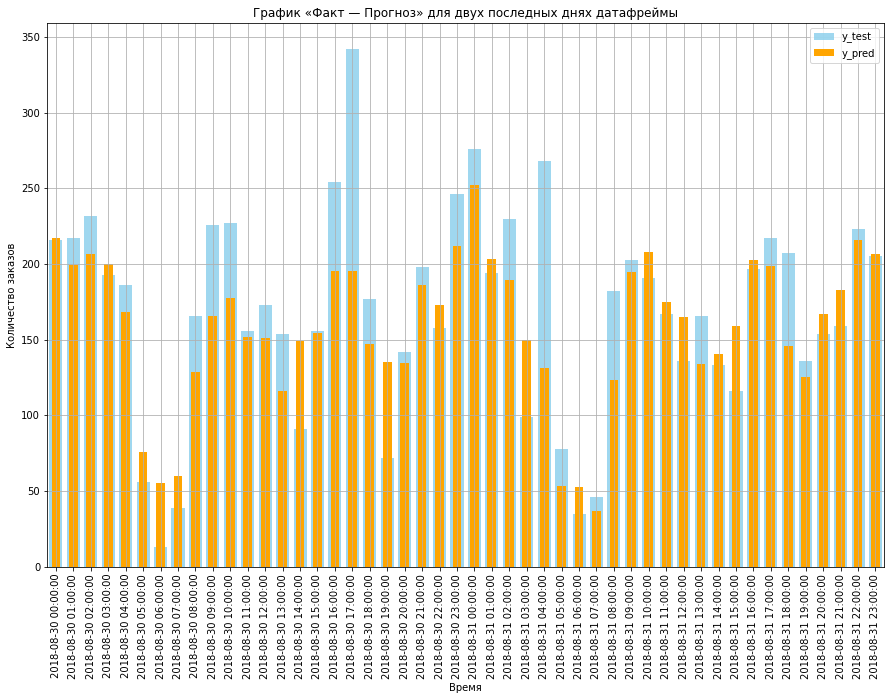

In [37]:
fig, ax = plt.subplots(figsize=(15,10))

ax = data.iloc[377:425]['y_test'].plot(kind='bar', color='skyblue', width=.75, legend=True, alpha=0.8)
data.iloc[377:425]['y_pred'].plot(kind='bar', color='orange', width=.5, alpha=1, legend=True);

ax.set_title(f'График «Факт — Прогноз» для двух последных днях датафреймы') 
ax.set_xlabel(f'Время')
ax.set_ylabel(f'Количество заказов')
ax.grid()

Похоже, что в целом прогнозы дают слишком низкие значения, когда истинные значения высоки, и слишком высокие значения, когда истинное значение низкое.

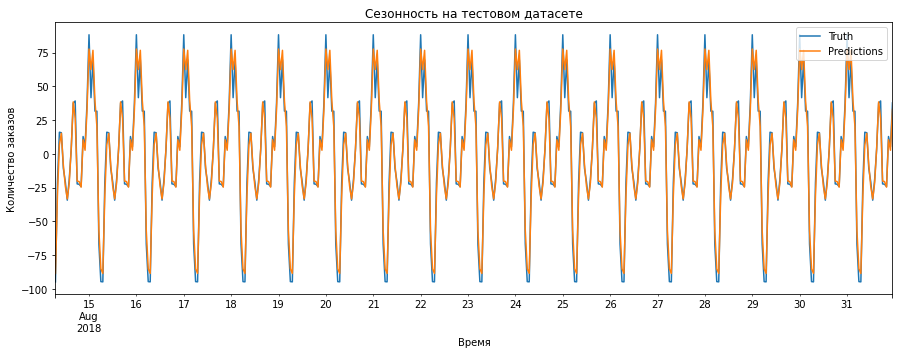

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
seasonal_decompose(data['y_test']).seasonal.plot(label='Truth');
seasonal_decompose(data['y_pred']).seasonal.plot(label='Predictions');
ax.set_title('Сезонность на тестовом датасете');
ax.set_xlabel('Время');
ax.set_ylabel('Количество заказов');
ax.legend();

Сезонность для предсказание - есть. Однако мы видим что его амплитуда меньше по сравнению с фактическами даннами.

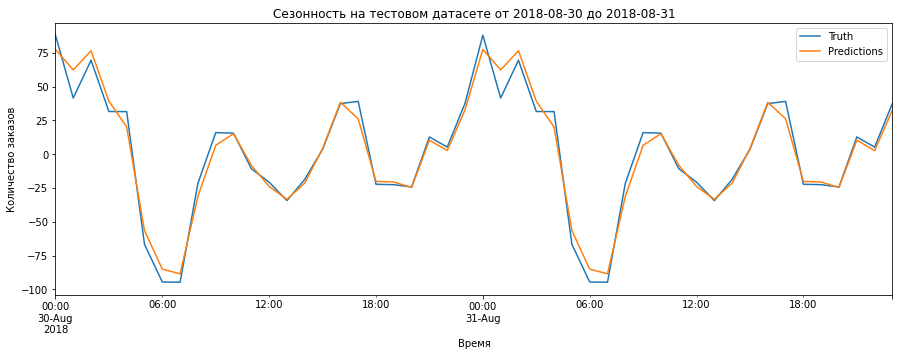

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
seasonal_decompose(data['y_test']).seasonal['2018-08-30':'2018-08-31'].plot(label='Truth');
seasonal_decompose(data['y_pred']).seasonal['2018-08-30':'2018-08-31'].plot(label='Predictions');
ax.set_title('Сезонность на тестовом датасете от 2018-08-30 до 2018-08-31');
ax.set_xlabel('Время');
ax.set_ylabel('Количество заказов');
ax.legend();

Прогноз на самом деле не польностю улавливает пики и минимумы, но при этом соблюдать сезонность фактических данных.

## DummyRegressor

In [40]:
# dummy regressor с strategy mean
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train) 
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 

In [41]:
# метрики на валидационны выборке для dummy regressor
rmse = round(root_mean_squared_error(y_test, y_predict_dummy_mean),2)
print(f'RMSE за лучшую модель : {rmse} orders')
r2 = round(r2_score(y_test, y_predict_dummy_mean),2)
print(f'R2 за лучшую модель : {r2:.2f}')

RMSE за лучшую модель : 84.45 orders
R2 за лучшую модель : -1.06


Наша лучшая модель дает лучший результат, чем модель DummyRegressor.

## Сравнение между lag(168) от предсказании и предыдушый недели от тестовой датасеты

In [42]:
data.head()

,y_test,y_pred
datetime,,
2018-08-14 07:00:00,54,41.239719
2018-08-14 08:00:00,91,89.669575
2018-08-14 09:00:00,135,108.774779
2018-08-14 10:00:00,155,123.463336
2018-08-14 11:00:00,162,107.659062


In [43]:
y_baseline_pred = data['y_pred'].shift(168)
y_baseline_pred = y_baseline_pred.dropna()
y_baseline_pred = y_baseline_pred[:'2018-08-28 07:00:00']
y_baseline_pred.shape

(169,)

In [44]:
y_baseline_test = y_test['2018-08-14 07:00:00':'2018-08-21 07:00:00']
y_baseline_test.shape

(169,)

In [45]:
# метрики на валидационны выборке для dummy regressor
rmse = round(root_mean_squared_error(y_baseline_test, y_baseline_pred),2)
print(f'RMSE за сравнение между lag(168) и предыдушый недели: {rmse} orders')

RMSE за сравнение между lag(168) и предыдушый недели: 33.31 orders


## Вывод

Получили метрик RMSE равно 34,26. 

Мы также проверили что наш модел быль адекватным.

# Обшее вывод

Наш набор данных состоял из двух столбцов: количества заказов и временные ряды которие мы использовали в качестве индекса, и проверили что они монотонно возрастали. Пропущенных значений или дубликатов обнаружено не было. Мы создали некоторые признаки из временных рядов, такие как 'hour' или скользящее среднее.

EDA показывает, что количество заказов начинает увеличиваться в конце апреля, что соответствует времени, когда люди берут отпуск, и достигает максимума в августе. Максимальное количетсво заказов - в пятницу и понедельнике, первый и последний рабочие дни. Время, когда делается большинство заказов, — ночь с 23:00 до 2:00 с пиком в 0:00. Вероятно, это время перед закрытием аэропорта. В течение дня заказы принимаются по максимуму около 16:00. Однако их все равно меньше, чем в 23:00.

Мы использовали 4 разные модели: LinearRegression, LGBMRegressor, RandomForestRegressor, KNeighborsRegressor. 
С помощью RandomizedGridCV, мы выяснили, что наша лучшая модель - LinearRegression(). 

RMSE полученное с помощью этой модели, равно 34,26.